# Cascade of two-neuron modules
*Nhat Le, November 2017*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
def ecdf(x):
    return np.sort(x), np.arange(len(x)) / len(x)

def save_safe(filename):
    '''Raise an error if file exists'''
    if not os.path.isfile(filename):
        plt.savefig(filename)
    else:
        raise IOError('File exists!')

def thresh_exp(x):
    '''Activation function'''
    return 1 / (1 + np.exp(-x))

def find_u_dot(state, params):
    '''Returns du/dt given the parameters and current state'''
    Wuv = params['Wuv']
    Wut = params['Wut']
    tau = params['tau']
    ext = params['ext']
    theta = params['theta']
    
    u = state['u']
    v = state['v']
    return (-u + thresh_exp(Wut * theta - Wuv * v + ext)) / tau

def find_v_dot(state, params):
    '''Returns dv/dt given the parameters and current state'''
    Wvu = params['Wvu']
    Wvt = params['Wvt']
    tau = params['tau']
    ext = params['ext']
    theta = params['theta']

    
    u = state['u']
    v = state['v']
    return (-v + thresh_exp(Wvt * theta - Wvu * u + ext)) / tau

def update_u_exp(state, params):
    '''Update u based on params'''
    state_new = state.copy()
    state_new['u'] += find_u_dot(state, params) * params['dt']
    return state_new

def update_v_exp(state, params):
    '''Update v based on params'''
    state_new = state.copy()
    state_new['v'] += find_v_dot(state, params) * params['dt']
    return state_new

def simulate_u_v_exp(state_init, params, niter):
    '''Simulate for niter iterations'''
    curr_state = state_init.copy()
    u_lst = [state_init['u']]
    v_lst = [state_init['v']]

    for i in range(niter):
        order = np.random.randint(0, 2)
        if order:
            curr_state = update_u_exp(curr_state, params)    
            curr_state = update_v_exp(curr_state, params)
        else:
            curr_state = update_v_exp(curr_state, params)    
            curr_state = update_u_exp(curr_state, params)
        v_lst.append(curr_state['v'])
        u_lst.append(curr_state['u'])
    return u_lst, v_lst

def find_u_dot_multi(state, params):
    '''Returns du/dt given the parameters and current state'''
    u = state['u']
    v = state['v']
    Wuv = params['Wuv']
    Wut = params['Wut']
    tau = params['tau']
    ext = params['ext']
    theta = params['theta']
    sigma = params['sigma']
        
    noise = np.random.normal(loc=0, scale=sigma, size=len(u))
    return (-u + thresh_exp(Wut * theta - Wuv * v + noise + ext)) / tau

def find_v_dot_multi(state, params):
    '''Returns dv/dt given the parameters and current state'''
    u = state['u']
    v = state['v']
    Wvu = params['Wvu']
    Wvt = params['Wvt']
    tau = params['tau']
    ext = params['ext']
    theta = params['theta']
    sigma = params['sigma']
        
    noise = np.random.normal(loc=0, scale=sigma, size=len(v))
    return (-v + thresh_exp(Wvt * theta - Wvu * u + noise + ext)) / tau

def update_u_exp_multi(state, params):
    '''Update u based on params'''
    state_new = state.copy()
    state_new['u']= state_new['u'] + find_u_dot_multi(state, params) * params['dt']
    return state_new

def update_v_exp_multi(state, params):
    '''Update v based on params'''
    state_new = state.copy()
    state_new['v'] = state_new['v'] + find_v_dot_multi(state, params) * params['dt']
    return state_new

def simulate_u_v_exp_multi(state_init, params, niter):
    '''Simulate for niter iterations'''
    curr_state = state_init.copy()
    u_lst = [state_init['u']]
    v_lst = [state_init['v']]

    for i in range(niter):
        order = np.random.randint(0, 2) # Choose to update u or v first
        if order:
            curr_state = update_u_exp_multi(curr_state, params)
            curr_state = update_v_exp_multi(curr_state, params) 
        else:
            curr_state = update_v_exp_multi(curr_state, params)
            curr_state = update_u_exp_multi(curr_state, params) 
        u_lst.append(curr_state['u'])
        v_lst.append(curr_state['v'])
        
    u_arr = np.vstack(u_lst)
    v_arr = np.vstack(v_lst)
    return u_arr, v_arr

def ecdf(data):
    return np.sort(data), np.arange(len(data)) / len(data)

def get_mean_and_sd_lines(state, params, nstep):
    '''Simulate for n steps and return two arrays, one for mean
    and one for SD across all trials'''
    ulst, vlst = simulate_u_v_exp_multi(state, params, nstep)
    return np.mean(ulst, axis=1), np.mean(vlst, axis=1), \
            np.std(ulst, axis=1), np.std(vlst, axis=1)

In [162]:
# Module 1!
ntrials = 100
nsteps = 5000
ext_module1 = np.random.normal(loc=0, scale=0.3, size=ntrials)
param_dict_module1 = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.5, 'tau': 100, 'dt': 1, 'ext': ext_module1, 'sigma': 0}

state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
ulst_noise1, vlst_noise1 = simulate_u_v_exp_multi(state_dict, param_dict_module1, 1000)
final_pos1 = (ulst_noise1 + vlst_noise1)[-1, :]

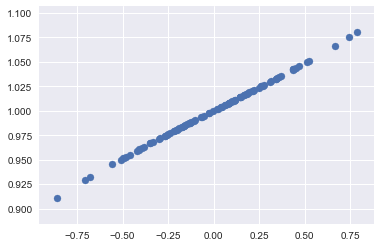

In [163]:
plt.scatter(ext_module1, final_pos1)

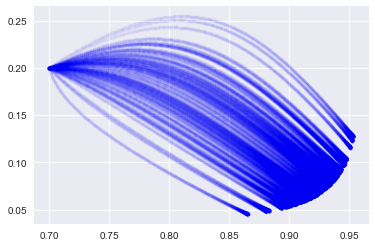

In [164]:
plt.plot(ulst_noise1, vlst_noise1, 'b.', alpha=0.05);

In [165]:
# Module 2!
ref2 = 1
k2 = 5
ext_module2 = (ext_module1 - k2 * (final_pos1 - ref2))

param_dict_module2 = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.5, 'tau': 100, 'dt': 1, 'ext': ext_module2, 'sigma': 0}

state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
ulst_noise2, vlst_noise2 = simulate_u_v_exp_multi(state_dict, param_dict_module2, 400)
decision_v2 = ulst_noise2 - vlst_noise2
final_pos2 = (ulst_noise2 + vlst_noise2)[-1, :]


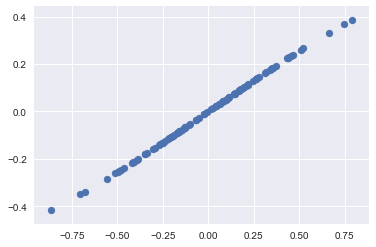

In [166]:
plt.scatter(ext_module1, ext_module2)

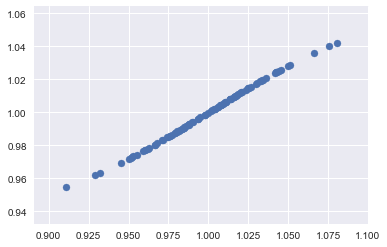

In [167]:
plt.scatter(final_pos1, final_pos2)

In [168]:
# Module 3!
ref3 = 1
k3 = 5
ext_module3 = (ext_module2 - k3 * (final_pos2 - ref3))

param_dict_module3 = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.5, 'tau': 100, 'dt': 1, 'ext': ext_module3, 'sigma': 0}

state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
ulst_noise3, vlst_noise3 = simulate_u_v_exp_multi(state_dict, param_dict_module3, 400)
decision_v3 = ulst_noise3 - vlst_noise3
final_pos3 = (ulst_noise3 + vlst_noise3)[-1, :]


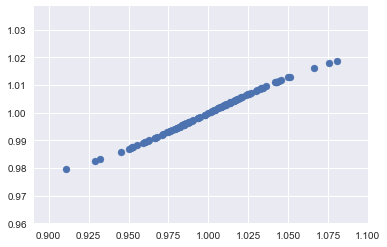

In [171]:
plt.scatter(final_pos1, final_pos3)

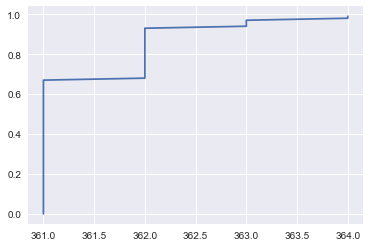

In [177]:
# Module 4 (readout)
ref4 = 1
k4 = 5
thresh = 0.8
ext_module4 = (ext_module3 - k4 * (final_pos3 - ref4))
param_dict_module4 = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.5, 'tau': 100, 'dt': 1, 'ext': ext_module4, 'sigma': 0}


ulst_noise4, vlst_noise4 = simulate_u_v_exp_multi(state_dict, param_dict_module4, 5000)
        
decision_v = ulst_noise4 - vlst_noise4
action_times = []
# Find time to act
for k in range(ntrials):
    # Check if the bound is reached (sometimes it's not!)
    if np.max(decision_v[:,k]) > thresh:
        action_times.append(np.nonzero(decision_v[:, k] > thresh)[0][0])
    else:
        action_times.append(np.inf)
        print('Bound not reached')
x, y = ecdf(action_times)
plt.plot(x, y)

## Effect of $\sigma_\sigma$

In [103]:
# Module 1!
ntrials = 100
nsteps = 1000
#ext_module1 = np.random.normal(loc=0, scale=0.1, size=ntrials)
param_dict_module1 = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.5, 'tau': 100, 'dt': 1, 'ext': 0, 'sigma': 0.1}

state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
ulst_noise1, vlst_noise1 = simulate_u_v_exp_multi(state_dict, param_dict_module1, nsteps)
final_pos1 = (ulst_noise1 + vlst_noise1)[-1, :]

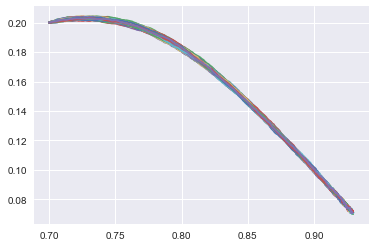

In [105]:
plt.plot(ulst_noise1, vlst_noise1);

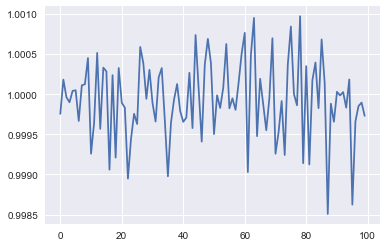

In [107]:
plt.plot(final_pos1)